In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import goes16s3
import time
import os


# Hurricane Michael

In [15]:
dayofyear = 283
year = 2018
n_channels = 8
image_group = 'images-hurricane-michael-10102018/'


## Download Data

In [78]:
import boto
import os
import pandas as pd
import xarray as xr
import utils

class NOAAGOESS3(object):
    '<Key: noaa-goes16,ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s20000011200000_e20000011200000_c20170671748180.nc>'
    def __init__(self, product='ABI-L1b-RadM', channels=range(1,17),
                       save_directory='/mnt/nexai-goes/GOES/S3'):
        self.bucket_name = 'noaa-goes16'
        self.product = product
        self.channels = channels
        self.conn = boto.connect_s3(host='s3.amazonaws.com')
        self.goes_bucket = self.conn.get_bucket(self.bucket_name)
        self.save_directory = os.path.join(save_directory, product)    
        
    def year_day_pairs(self):
        days = []
        for key_year in self.goes_bucket.list(self.product+"/", "/"):
            y = int(key_year.name.split('/')[1])
            if y == 2000:
                continue
            for key_day in self.goes_bucket.list(key_year.name, "/"):
                d = int(key_day.name.split('/')[2])
                days += [(y, d)]
        return days
    
    def day_keys(self, year, day, hours=range(12,24)):
        keybase = '%(product)s/%(year)04i/%(day)03i/' % dict(product=self.product,
                                                           year=year, day=day)
        data = []
        for key_hour in self.goes_bucket.list(keybase, "/"):
            hour = int(key_hour.name.split('/')[3])
            if hour not in hours:
                continue

            for key_nc in self.goes_bucket.list(key_hour.name, '/'):
                fname = key_nc.name.split('/')[4]
                info = fname.split('-')[3]
                c, g, t, _, _ = info.split("_")
                spatial = fname.split('-')[2]
                c = int(c[3:])
                if c not in self.channels:
                    continue
                minute = int(t[10:12])
                second = int(t[12:15])
                data.append(dict(channel=c, year=year, day=day, hour=hour,
                                 minute=minute, second=second, spatial=spatial,
                                 keyname=key_nc.name))
                #if len(data) > 100:
                #    break

        return pd.DataFrame(data)

    def _open_file(self, f, normalize=True):
        try:
            ds = xr.open_dataset(f)
        except IOError:
            os.remove(f)
            return None

        if normalize:
            mn = ds['min_radiance_value_of_valid_pixels'].values
            mx = ds['max_radiance_value_of_valid_pixels'].values
            ds['Rad'] = (ds['Rad'] - mn) / (mx - mn)
        return ds

    def download_from_s3(self, keyname, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)
        k = boto.s3.key.Key(self.goes_bucket)
        k.key = keyname
        data_file = os.path.join(directory, os.path.basename(keyname))
        if os.path.exists(data_file):
            pass
        elif k.exists():
            print("writing file to {}".format(data_file))
            k.get_contents_to_filename(data_file)
        else:
            data_file = None
        return data_file

    def read_nc_from_s3(self, keyname, normalize=True):
        data_file = self.download_from_s3(keyname, self.save_directory)
        if data_file is not None:
            ds = self._open_file(data_file, normalize=normalize)
            if ds is None:
                self.read_nc_from_s3(keyname, normalize=normalize)
        else:
            ds = None
            data_file = None
        return ds, data_file

    def read_day(self, year, day, hours=range(12,25),
                 store_files=True):
        '''
        Reads and joins product data for entire day in temporal order.
        args:
            year: int
            day: int
        returns:
            list(xarray.DataArray)
        '''
        t0 = time.time()
        keys_df = self.day_keys(year, day, hours=hours)
        if len(keys_df) == 0: return

        grouped_spatial = keys_df.groupby(by=['spatial'])
        daily_das = []
        for sname, sgrouped in grouped_spatial: #max of 2 groups
            grouped_hourly = sgrouped.groupby(by=["hour"])
            for hname, hgroup in grouped_hourly: #limited to 24
                print("Day", day, "Hour", hname)
                hourly_das = []
                hourly_files = []
                grouped_minutes = hgroup.groupby(by=['minute'])

                for mname, mgroup in grouped_minutes: # 60 minutes
                    mds = []
                    for i in mgroup.index:
                        ds, f = self.read_nc_from_s3(mgroup.loc[i].keyname)
                        hourly_files.append(f)
                        if (f is None) or (ds is None):
                            break

                        if mgroup.loc[i].channel in [1,3,5]: #(1 km)
                            newds = utils.interp_da2d(ds.Rad, 1./2, fillna=False)
                        elif mgroup.loc[i].channel == 2: #(0.5 km)
                            newds = utils.interp_da2d(ds.Rad, 1./4, fillna=False)
                        else:
                            newds = ds.Rad

                            del newds['x_image']
                            del newds['y_image']
                            del newds['t']

                        newds['band'] = mgroup.loc[i].channel
                        mds.append(newds)
                        try:
                            mds[-1]['x'].values = mds[0]['x'].values
                            mds[-1]['y'].values = mds[0]['y'].values
                        except ValueError:
                            print('spatial', sname, 'hname', hname, 'mname', mname,
                                  'mds[-1]', mds[-1], 'mds[0]', mds[0])
                            raise
                    if f is None: # missing a minute in this hour, just skip it for now
                        print("f is none")
                        break

                    mds = xr.concat(mds, dim='band')
                    if ds is None:
                        break
                    mds['t'] = ds['t']
                    hourly_das.append(mds)
                    # in this case, a snapshot is being captured every 30 seconds, ignore the hour
                    if np.unique(mds.band.values).size < mds.band.shape[0]:
                        print("This hour has more than 1 snapshot per minute, skip it.")
                        hourly_das = []
                        break

                if len(hourly_das) == 0: continue

                x0 = hourly_das[0].x.values
                xn = hourly_das[-1].x.values
                y0 = hourly_das[0].y.values
                yn = hourly_das[-1].y.values

                if not np.all(x0 == xn): print("x Indicies do not match"); continue
                if not np.all(y0 == yn): print("y Indicies do not match"); continue

                hourly_das = xr.concat(hourly_das, dim='t')
                yield hourly_das

                if not store_files:
                    [os.remove(f) for f in hourly_files]
    

    def local_files(self, year=None, dayofyear=None):
        data = []
        for f in os.listdir(self.save_directory):
            meta = get_filename_metadata(f)
            if (year is not None) and (year == meta['year']):
                continue
            if (dayofyear is not None) and (dayofyear == meta['dayofyear']):
                continue
            meta['file'] = os.path.join(self.save_directory, f)
            data.append(meta)
        data = pd.DataFrame(data)
        data = data.set_index(['year', 'dayofyear', 'hour', 'minute', 'second', 'spatial'])
        data = data.pivot(columns='channel')
        return data
    
    
    
    
def get_filename_metadata(f):
    channel = int(f.split('_')[1][-2:])
    spatial = f.split('-')[2]
    t1 = f.split('_')[3]
    year = int(t1[1:5])
    dayofyear = int(t1[5:8])
    hour = int(t1[8:10])
    minute = int(t1[10:12])
    second = int(t1[12:15])
    return dict(channel=channel, year=year, dayofyear=dayofyear, hour=hour,
                minute=minute, second=second, spatial=spatial)

def regrid_2km(da, band):
    if band in [1,3,5]: #(1 km)
        da = utils.interp_da2d(da, 1./2, fillna=False)
    elif band == 2: #(0.5 km)
        da = utils.interp_da2d(da, 1./4, fillna=False)
    return da

def _open_and_merge_2km(files):
    '''
    This method opens a list of S3 NOAA ABI files,
        normalizes by max and min radiances,
        and interpolations to 2km.
    Return:
        xarray.DataArray (band: len(files), x, y)
    '''
    das = []
    for f in files:
        ds = xr.open_dataset(f)
        
        # normalize radiance
        mn = ds['min_radiance_value_of_valid_pixels'].values
        mx = ds['max_radiance_value_of_valid_pixels'].values
                
        ds['Rad'] = (ds['Rad'] - mn) / (mx - mn)
        #ds['Rad'] *= 1e-3
        # regrid to 2km to match all bands
        newrad = regrid_2km(ds['Rad'], ds.band_id.values[0])
        newrad = newrad.expand_dims(dim="band")
        newrad = newrad.assign_coords(band=ds.band_id.values)
        
        # for some reason, these coordinates are included in band 4
        if 't' in newrad.coords:
            newrad = newrad.drop('t')
        if 'y_image' in newrad.coords:
            newrad = newrad.drop('y_image')
        if 'x_image' in newrad.coords:
            newrad = newrad.drop('x_image')
            
        das.append(newrad)
        
        # reindex so the concatenation works correctly
        #das[-1] = das[-1].reindex({'x': das[0].x.values, 
        #                           'y': das[0].y.values})
        das[-1] = das[-1].assign_coords(x=das[0].x.values,
                                        y=das[0].y.values)
    # concatenate each file by band after interpolating to the same grid
    das = xr.concat(das, 'band')
    return das

In [79]:
noaa = NOAAGOESS3(channels=range(1,n_channels+1), product='ABI-L1b-RadC')
iterator = noaa.read_day(year, dayofyear)
# for _ in iterator:
 #   pass

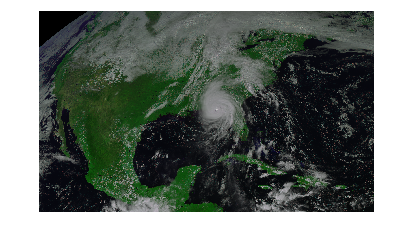

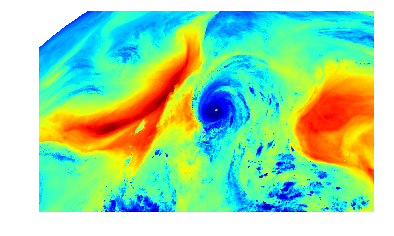

In [86]:
files = noaa.local_files()

dayfiles = files.loc[year, dayofyear].values
row = dayfiles[dayfiles.shape[0]/2]
rgbfiles = row[:3]
radrgb = _open_and_merge_2km(rgbfiles)
rgb = np.transpose(radrgb.values[[1,2,0]], (1,2,0))

plt.imshow(np.log(rgb+1.))
plt.axis('off')
plt.show()

# water vapor
wvfile = [row[7]]
wvrad = _open_and_merge_2km(wvfile)
plt.imshow(wvrad.values[0], cmap='jet')
plt.axis('off')
plt.show()


In [87]:
images = []
image_path = image_group + 'original-resolution/'
wv_image_path = image_group + 'original-watervapor-upper/'
if not os.path.exists(image_path):
    os.makedirs(image_path)
if not os.path.exists(wv_image_path):
    os.makedirs(wv_image_path)
def add_timestamp_to_image(img_file, img_date):
    datestr = img_date.strftime("%m/%d/%Y %H:%M")
    cmd = 'convert %s -gravity northwest -pointsize 32 -fill white -annotate +30+30  "%s" %s' % (img_file, datestr, img_file)
    return os.system(cmd)
    
img_counter = 0
for i, row in files.loc[year, dayofyear].iterrows():
    rowfiles = row.values[:n_channels]
    rad = _open_and_merge_2km(rowfiles)
    #rgb = np.transpose(rad.values[[1,2,0]], (1,2,0))
    wv = rad.values[7]
    
    image_file = image_path + 'img-%05i.png' % img_counter
    wv_file = wv_image_path + 'img-%05i.png' % img_counter
    images.append(image_file)
    #plt.imsave(images[-1], rgb)

    plt.imsave(wv_file, wv, cmap='jet')
    
    hour, minute, _, _ = row.name
    imgdate = datetime.datetime(year, 1, 1) + datetime.timedelta(dayofyear - 1, hours=hour, minutes=minute)
    
    #add_timestamp_to_image(image_file, imgdate)
    add_timestamp_to_image(wv_file, imgdate)
    
    img_counter += 1


In [89]:
fps = 16
video_file = os.path.join(image_path, 'video-%02dFPS.mp4' % fps)
if os.path.exists(video_file):
    os.remove(video_file)
    
cmd = 'ffmpeg -r {} -i {}/img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {}'.format(fps, image_path, video_file)
os.system(cmd)




0

In [91]:
# Make Water vapor video
wv_video_file = os.path.join(wv_image_path, 'video-%02dFPS.mp4' % fps)
if os.path.exists(wv_video_file):
    os.remove(wv_video_file)
    
cmd = 'ffmpeg -r {} -i {}/img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {}'.format(fps, wv_image_path, wv_video_file)
os.system(cmd)

0

In [85]:
import inference_tools

model_path = './saved-models/5Min-%iChannels/' % n_channels
flownet, interpnet, warper = inference_tools.load_models(n_channels, model_path, False)

=> no checkpoint found at './saved-models/5Min-8Channels/checkpoint.flownet.pth.tar'


In [9]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def inference_5min(X0, X1, flownet, interpnet, warper, 
                   multivariate, T=4, block_size=None):
    '''
    Given two consecutive frames, interpolation T between them 
        using flownet and interpnet
    Returns:
        Interpolated Frames
    '''
    
    X0_arr_torch = torch.from_numpy(X0.values)
    X1_arr_torch = torch.from_numpy(X1.values)

    # nans to 0
    X0_arr_torch[np.isnan(X0_arr_torch)] = 0.
    X1_arr_torch[np.isnan(X1_arr_torch)] = 0.
    
    X0_arr_torch = torch.unsqueeze(X0_arr_torch, 0).to(device)
    X1_arr_torch = torch.unsqueeze(X1_arr_torch, 0).to(device)

    f = flownet(X0_arr_torch, X1_arr_torch)
    n_channels = X0_arr_torch.shape[1]
        
    if multivariate:
        f_01 = f[:,:2*n_channels]
        f_10 = f[:,2*n_channels:]
    else:
        f_01 = f[:,:2]
        f_10 = f[:,2:]
        
    predicted_frames = []
    
    for j in range(1,T+1):
        t = 1. * j / (T+1)
        I_t, g0, g1, V_t0, V_t1, delta_f_t0, delta_f_t1 = interpnet(X0_arr_torch, X1_arr_torch, f_01, f_10, t)
        predicted_frames.append(I_t.cpu().detach().numpy())

    torch.cuda.empty_cache()
    return predicted_frames
    
def inference_5min_conus(X0, X1, flownet, interpnet, warper, 
                   multivariate, T=4, block_size=None):
    '''
    Given two consecutive frames, interpolation T between them 
        using flownet and interpnet
    Returns:
        Interpolated Frames
    '''
    # Get a list of dataarrays chunked
    X0_blocks = utils.blocks(X0, width=2*352)
    X1_blocks = utils.blocks(X1, width=2*352)

    interpolated_blocks = []
    for x0, x1 in zip(X0_blocks, X1_blocks):
        predicted_frames = inference_5min(x0, x1, flownet, 
                                          interpnet, warper,
                                          multivariate, T, 
                                          block_size)
        predicted_frames = [x0.values[np.newaxis]] + predicted_frames + [x1.values[np.newaxis]]
        interpolated_blocks += [inference_tools.block_predictions_to_dataarray(predicted_frames, x0)]
    return inference_tools.merge_and_average_dataarrays(interpolated_blocks)


X0 = None
X1 = None
T = 4

image_path = image_group + '1minute-resolution/'
if not os.path.exists(image_path):
    os.makedirs(image_path)
    
images = []
img_counter = 0
for i, row in files.loc[year, dayofyear].iterrows():
    rgbfiles = row.values[:3]
    X1 = _open_and_merge_2km(rgbfiles)
    if X0 is not None:
        XT = inference_5min_conus(X0, X1, flownet, interpnet, warper, False,
                       T=T, block_size=None)
        for i in range(T+1):
            rgb = np.transpose(XT.values[i][[1,2,0]], (1,2,0))
            images.append(image_path + 'img-%05i.png' % img_counter)
            plt.imsave(images[-1], rgb[::-1])
            img_counter += 1
            
            # T=0 minute=minute
            # T=1 minute=minute+5
            # T=t minute=minute+t*5
            
            hour, minute, _, _ = row.name
            minute = minute + 5*i/(T+1)
            imgdate = datetime.datetime(year, 1, 1) + datetime.timedelta(dayofyear - 1, hours=hour, minutes=minute)
            datestr = imgdate.strftime("%m/%d/%Y %H:%M")
            add_timestamp_to_image(images[-1], datestr)
            
        
    X0 = X1


In [10]:
fps = 80
video_file = os.path.join(image_path, 'video-%02dFPS.mp4' % fps)
if os.path.exists(video_file):
    os.remove(video_file)
    
cmd = 'ffmpeg -r {} -i {}/img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {}'.format(fps, image_path, video_file)
print(cmd)
os.system(cmd)


ffmpeg -r 80 -i images-hurricane-michael-10102018/1minute-resolution//img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p images-hurricane-michael-10102018/1minute-resolution/video-80FPS.mp4


0